## Sea Performance Model

The performace of the system as a whole can be broken down into three components: 1) The amount of time it takes
to read the data from Lustre, 2) the amount of time it takes to read and write the required data to memory, and 3) the amount of time it takes to read and write the data to disk. 

First, we shall devise a simplified performance model for Lustre alone, as this will give us an upper bound to the 
added performance of Sea. We describe Lustre's performance as follows:

$$ M_{l} =  \frac{D_{in}I}{\min{(B_{n}N_{c}, B_{n}N_{d}, B_{lr}\min{(O, nN_{c}}))}} + \frac{D_{in}I}{\min{(B_{n}N_{c}, B_{n}N_{d}, B_{lw}\min{(O, nN_{c}}))}}$$

$\text{Where,}$<br>
$M_{l}$ represents Lustres makespan<br>
$D_{in}$ is the size of the input dataset<br>
$I$ is the total number of iterations<br>
$O$ is the number of Lustre OSTs<br>
$N_{c}$ is the number of compute nodes<br>
$N_{d}$ is the number of data nodes<br>
$B_{n}$ is the network bandwidth<br>
$B_{lr}$ is a Lustre OST's read bandwidth<br>
$B_{lw}$ is a Lustre OST's write bandwidth<br>

Essentially, the makespan can be descriped as the total time it takes to read and write all the data to and from Lustre. Lustre can have a bottleneck in one of two places: within the network transfer, due to limited network bandwidth, or the OSTs, due to collective disk bandwidths. It is important to account for both of these bottlenecks as they may fluctuate depending on the number of compute nodes required for a given experiment.


### The Linux Page Cache Model


The aforementioned models are imperfect in that they describe a scenario in which data outside of Sea is not cached in memory. This is an unlikely case as many systems leverage, by default, the page cache in order speed up I/O to non-volatile storage media.

The model to calculate the amount of data that can be read from page cache is very similar to the model for Sea's tmpfs reads. The exception is that available storage is no longer a fixed value as available memory is shared between file data and applications objects. The memory occupation of a task is expected to be that of the size of a single file. Therefore, the amount of memory used by application objects corresponds to the total amount of memory used by the total number of concurrent tasks. The remainder of the memory is therefore available to be occupied by the page cache.

The amount of data that will be read from page cache is as follows:

$$D_{cr} = \min\left[N_{c}\left(A - \frac{Fn}{2}\right), D_{in}\right](I-1)$$

Where,<br>
$D_{cr}$ is the amount of data read from page cache<br>
$D_{in}$ is the input dataset size<br>
$N_{c}$ is the number of compute nodes<br>
$I$ is the number of iterations<br>
$A$ is the amount of available memory<br>
$F$ is the file size<br>
$n$ is the number of threads in a node<br>


Unlike with reads, cached writes are limited to a certain percentage of available memory, known as the dirty ratio. Therefore, the amount of data that can be written to memory without being impacted by the rate of disk writes is limited by the percentage of available page cache space that can be used for writes.

The amount of data that can be written with memory bandwidth is as follows:

$$D_{cw} = \min\left[CN_{c}\left(A - \frac{Fn}{2}\right), D_{in}\right]I$$

Where,<br>
$D_{cw}$ is the amount of data written to cache without throttling<br>
$D_{in}$ is the input dataset size<br>
$N_{c}$ is the number of compute nodes<br>
$I$ is the number of iterations<br>
$C$ is the percentage of page cache that can be occupied by dirty data
$A$ is the amount of available memory<br>
$F$ is the file size<br>



The page cache model can be described as follows:

$$M_{pc} = \frac{D_{cr}}{B_{mr}N_{c}} + \frac{D_{cw}}{B_{mw}N_{c}}$$

Where,<br>
$M_{pc}$ is the makespan of reading and writing to page cache<br>
$D_{cr}$ is the amount of data read from page cache<br>
$D_{cw}$ is the amount of data written with memory bandwidth<br>
$N_{c}$ is the number of compute nodes<br>
$B_{mr}$ is the bandwidth of a memory read<br>
$B_{mw}$ is the bandwidth of a memory write<br>


Therefore, the Lustre makespan model can be rewritten as:

$$M_{l} =  \underbrace{\frac{D_{in}}{\min{(B_{n}N_{c}, B_{n}N_{d}, B_{lr}O)}}}_\text{Lustre initial read} + \underbrace{M_{pc}}_\text{page cache makespan} + \underbrace{\frac{D_{in}(I-1) - D_{cr}}{\min{(B_{n}N_{c}, B_{n}N_{d}, B_{lr}O)}}}_\text{non-cached reads} + \underbrace{\frac{D_{in}I - D_{cw}}{\min{(B_{n}N_{c}, B_{n}N_{d}, B_{lw}O)}}}_\text{non-cached writes}$$

Where,<br>
$M_{l}$ represents Lustres makespan<br>
$D_{in}$ is the size of the input dataset<br>
$D_{cr}$ is the amount of data read from page cache<br>
$D_{cw}$ is the amount of data written with memory bandwidth<br>
$I$ is the total number of iterations<br>
$O$ is the number of Lustre OSTs<br>
$N$ is the number of compute nodes<br>
$B_{n}$ is the network bandwidth<br>
$B_{lr}$ is a Lustre OST's read bandwidth<br>
$B_{lw}$ is a Lustre OST's write bandwidth<br>
$B_{mr}$ is the bandwidth of a memory read<br>
$B_{mw}$ is the bandwidth of a memory write<br>


In [1]:
# lustre redone

M_l = (lambda
       D_in,
       I,
       O,
       n,
       N_c,
       N_d,
       B_n,
       B_lr,
       B_lw : ((D_in * I)/ min(B_n * N_c, B_n * N_d, B_lr * min(O, n * N_c))) 
       + ((D_in * I)/ min(B_n * N_c, B_n * N_d, B_lw * min(O, n * N_c)))
)

D_cr = (lambda
        D_in,
        N_c,
        N_d,
        I,
        A,
        F,
        n : min(N_c * (A - ((F * n)/2)),500*n*N_c, D_in)*(I-1)
       )

D_cw = (lambda
        D_in,
        N_c,
        N_d,
        I,
        C,
        A,
        F,
        n : min(C * N_c * (A - ((F * n)/2)), 500*n*N_c, D_in)*I
        )

M_pc = (lambda
        D_in,
        N_c,
        N_d,
        I,
        C,
        A,
        F,
        n,
        B_mr,
        B_mw : (D_cr(D_in, N_c, N_d, I, A, F, n) / (B_mr * N_c)) + (D_cw(D_in, N_c, N_d, I, C, A, F, n)/ (B_mw * N_c))
        )

M_lpc = (lambda
         D_in,
         N_c,
         N_d,
         I,
         C,
         A,
         F,
         n,
         O,
         B_n,
         B_lr,
         B_lw,
         B_mr,
         B_mw:
         (D_in / min(B_n * N_c, B_n * N_d, B_lr * min(O, n*N_c)))
         + M_pc(D_in, N_c, N_d, I, C, A, F, n, B_mr, B_mw)
         + (((D_in * (I - 1)) - D_cr(D_in, N_c, N_d, I, A, F, n))/ min(B_n * N_c, B_n * N_d, B_lr * min(O, n*N_c)))
         + (((D_in * I) - D_cw(D_in, N_c, N_d, I, C, A, F, n)) / min(B_n * N_c, B_n * N_d, B_lw * min(O, n*N_c) )))


### Model evaluation - Network bandwidth

(0.0, 103.9)

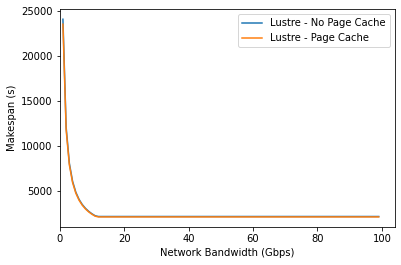

In [2]:
bw = range(128, 100*128, 128)
gbps = [b/128 for b in bw]

F = 617
n_f = 1000
D_in = F * n_f
N_c = 5
N_d = 4
I = 10
C = 0.40
A = 200 * 1024
n = 6
O = 44
B_n = 25 * 128
B_lr = 200
B_lw = 191
B_mr = 6760 * 7
B_mw = 2560 * 7

lustre_npc = [M_l(D_in, I, O, n, N_c, N_d, b, B_lr, B_lw) for b in bw]
lustre_pc = [M_lpc(D_in, N_c, N_d, I, C, A, F, n, O, b, B_lr, B_lw, B_mr, B_mw) for b in bw]

import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(x=gbps, y=lustre_npc, label="Lustre - No Page Cache")
sns.lineplot(x=gbps, y=lustre_pc, label="Lustre - Page Cache")
plt.xlabel("Network Bandwidth (Gbps)")
plt.ylabel("Makespan (s)")
plt.xlim(0)

### Model evaluation - Number of nodes

,experiment,repetition,runtime,flush_time,disk_files,total_flush,nodes
0,lustre,0,759.337704,NaN,0,0,5
3,lustre,0,1022.493378,NaN,0,0,3
7,lustre,1,1030.414540,NaN,0,0,3
10,lustre,1,785.365151,NaN,0,0,5
12,lustre,2,790.516604,NaN,0,0,5
15,lustre,2,1038.711835,NaN,0,0,3
19,lustre,3,1074.631137,NaN,0,0,3
21,lustre,3,808.176253,NaN,0,0,5
24,lustre,4,1089.690720,NaN,0,0,3
25,lustre,4,799.532235,NaN,0,0,5


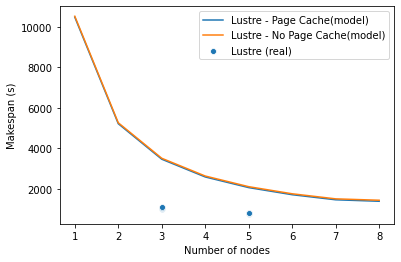

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

nodes = range(1,9)
lustre_npc = [M_l(D_in, I, O, n, nc, N_d, B_n, B_lr, B_lw) for nc in nodes]
lustre_pc = [M_lpc(D_in, nc, N_d, I, C, A, F, n, O, B_n, B_lr, B_lw, B_mr, B_mw) for nc in nodes]

df = pd.read_csv("../results/exp_6t_5i_n35.out")
df["nodes"] = df["experiment"].apply(lambda row: int(row.split('n_')[0].split("_")[-1]))
df["experiment"] = df["experiment"].apply((lambda row: row.split("_")[0] if "lustre" in row else row.split("_")[1]))

df_lustre=df[df["experiment"] == "lustre"]
df_last=df[df["experiment"] == "mem"]

sns.lineplot(x=nodes, y=lustre_pc, label="Lustre - Page Cache(model)")
sns.lineplot(x=nodes, y=lustre_npc, label="Lustre - No Page Cache(model)")
sns.scatterplot(data=df_lustre, x="nodes", y="runtime", label="Lustre (real)")
plt.xlabel("Number of nodes")
plt.ylabel("Makespan (s)")
df_lustre

### Model evaluation - Number of disks

Text(0, 0.5, 'Makespan (s)')

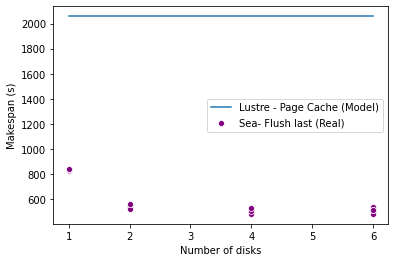

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

nodes = 5
bw = 4*8
disks = range(1, 7)

lustre = [M_lpc(D_in, N_c, N_d, I, C, A, F, n, O, B_n, B_lr, B_lw, B_mr, B_mw) for d in disks]

df = pd.read_csv("../results/experiment_disks.out")
df = df[(df["experiment"].str.contains("mem"))]
df["disks"] = df["experiment"].apply(lambda name: int(name.split("d_")[0].split("_")[-1]))
df = df.sort_values(by=['disks'])

sns.lineplot(x=disks, y=lustre, label="Lustre - Page Cache (Model)")
sns.scatterplot(data=df, x="disks", y="runtime", label="Sea- Flush last (Real)", color="purple")
plt.xlabel("Number of disks")
plt.ylabel("Makespan (s)")

### Model evaluation - Number of iterations

(0.0, 20.0)

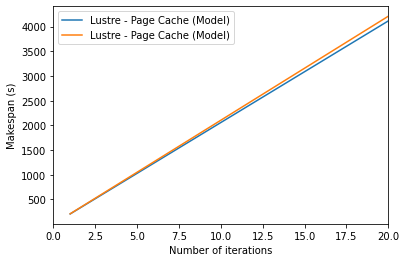

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

nodes = 5
bw = 4*8
d = 6
n_iterations = range(1, 21)

lustre = [M_lpc(D_in, N_c, N_d, i, C, A, F, n, O, B_n, B_lr, B_lw, B_mr, B_mw) for i in n_iterations]
lustre_npc = [M_l(D_in, i, O, n, N_c, N_d, B_n, B_lr, B_lw) for i in n_iterations]


sns.lineplot(x=n_iterations, y=lustre, label="Lustre - Page Cache (Model)")
sns.lineplot(x=n_iterations, y=lustre_npc, label="Lustre - Page Cache (Model)")
plt.xlabel("Number of iterations")
plt.ylabel("Makespan (s)")
plt.xlim(0, 20)

### Model evaluation - Number of files

(0.0, 35824.60732984293)

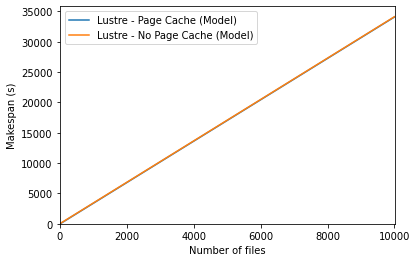

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

nodes = 5
bw = 4*8
d = 6
i = 5
num_files = range(0, 10001)

lustre = [M_lpc(f*n_f, N_c, N_d, I, C, A, F, n, O, B_n, B_lr, B_lw, B_mr, B_mw) for f in num_files]
lustre_npc = [M_l(f*n_f, I, O, n, N_c, N_d, B_n, B_lr, B_lw) for f in num_files]

sns.lineplot(x=num_files, y=lustre, label="Lustre - Page Cache (Model)")
sns.lineplot(x=num_files, y=lustre_npc, label="Lustre - No Page Cache (Model)")
plt.xlabel("Number of files")
plt.ylabel("Makespan (s)")
plt.xlim(0,10001)
plt.ylim(0)

### Model evaluation - Number of threads

12582.429088889614 12630.732984293194


(0.0, 13207.008031688409)

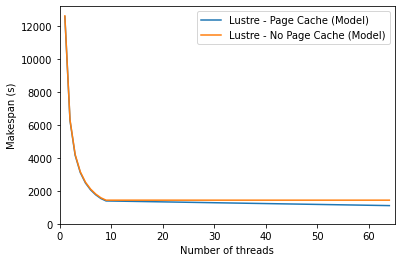

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

threads = range(1, 65)

lustre = [M_lpc(D_in, N_c, N_d, I, C, A, F, t, O, B_n, B_lr, B_lw, B_mr, B_mw) for t in threads]
lustre_npc = [M_l(D_in, I, O, t, N_c, N_d, B_n, B_lr, B_lw) for t in threads]
print(lustre[0], lustre_npc[0])

sns.lineplot(x=threads, y=lustre, label="Lustre - Page Cache (Model)")
sns.lineplot(x=threads, y=lustre_npc, label="Lustre - No Page Cache (Model)")

plt.xlabel("Number of threads")
plt.ylabel("Makespan (s)")
plt.xlim(0,65)
plt.ylim(0)

## Read only experiments - 1 iteration

('3', 9600, 12800, 3600, '5', 16000, 12800, 6000, '8', 25600, 12800, 8800)

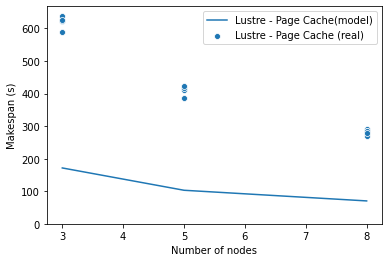

In [8]:
df = pd.read_csv("../results/exp_lustre_r.out")
df["nodes"] = df["experiment"].apply(lambda cell: int(cell.split("_")[1].rstrip("n")))

nodes = [3, 5, 8]
I = 1

M_lr = (lambda
       D_in,
       I,
       O,
       n,
       N_c,
       N_d,
       B_n,
       B_lr,
       B_lw : ((D_in * I)/ min(B_n * N_c, B_n * N_d, B_lr * min(O, n * N_c))) 
)

M_lpcr = (lambda
         D_in,
         N_c,
         N_d,
         I,
         C,
         A,
         F,
         n,
         O,
         B_n,
         B_lr,
         B_lw,
         B_mr,
         B_mw:
         (D_in / min(B_n * N_c, B_n * N_d, B_lr*min(O, n*N_c)))
         + M_pc(D_in, N_c, N_d, I, C, A, F, n, B_mr, B_mw)
         + (((D_in * (I - 1)) - D_cr(D_in, N_c, N_d, I, A, F, n))/ min(B_n * N_c, B_n * N_d, B_lr*min(O, n*N_c))))

#B_lr=200
#B_n = 25*128

lustre_npc = [M_lr(D_in, I, O, n, nc, N_d, B_n, B_lr, B_lw) for nc in nodes]
lustre_pc = [M_lpcr(D_in, nc, N_d, I, C, A, F, n, O, B_n, B_lr, B_lw, B_mr, B_mw) for nc in nodes]
lustre_avg = [sum(x)/2 for x in zip(lustre_pc, lustre_npc)]

sns.lineplot(x=nodes, y=lustre_pc, label="Lustre - Page Cache(model)")
#sns.lineplot(x=nodes, y=lustre_npc, label="Lustre - No Page Cache(model)")
#sns.lineplot(x=nodes, y=lustre_avg, label="Lustre - Average Cache(model)")

sns.scatterplot(data=df, x="nodes", y="runtime", label="Lustre - Page Cache (real)")
plt.xlabel("Number of nodes")
plt.ylabel("Makespan (s)")
plt.ylim(0)

#****ADD LS experiment multiple threads 1 node
"3", 3*B_n, 4*B_n, 200*min(44, 6*3), "5", 5*B_n, 4*B_n, 200*min(44, 6*5), "8",8*B_n, 4*B_n, 200*min(44, 6*8)

$$ M_{l} =  \frac{D_{in}I}{\min{(B_{n}N_{c}, B_{n}N_{d}, B_{lr}\min{(O, nN_{c}}))}} + \frac{D_{in}I}{\min{(B_{n}N_{c}, B_{n}N_{d}, B_{lw}\min{(O, nN_{c}}))}}$$

$\text{Where,}$<br>
$M_{l}$ represents Lustres makespan<br>
$D_{in}$ is the size of the input dataset<br>
$I$ is the total number of iterations<br>
$O$ is the number of Lustre OSTs<br>
$N_{c}$ is the number of compute nodes<br>
$N_{d}$ is the number of data nodes<br>
$B_{n}$ is the network bandwidth<br>
$B_{lr}$ is a Lustre OST's read bandwidth<br>
$B_{lw}$ is a Lustre OST's write bandwidth<br>

## Read/Write experiments - 1 iteration

171.38888888888889
179.46480511925537
0.16741071428571427
0.0
176.84700407213495


(0, 9000)

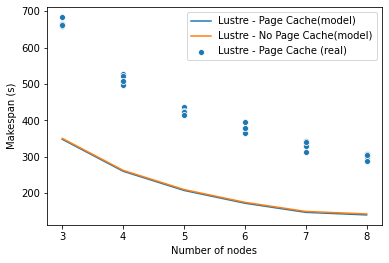

In [9]:
df = pd.read_csv("../results/exp_lustre_rw.out")
df["nodes"] = df["experiment"].apply(lambda cell: int(cell.split("_")[1].rstrip("n")))

nodes = range(3,9)
I = 1
n = 6
#A=200*1024
lustre_npc = [M_l(D_in, I, O, n, nc, N_d, B_n, B_lr, B_lw) for nc in nodes]
lustre_pc = [M_lpc(D_in, nc, N_d, I, C, A, F, n, O, B_n, B_lr, B_lw, B_mr, B_mw) for nc in nodes]
#lustre_avg = [sum(x)/2 for x in zip(lustre_pc, lustre_npc)]

sns.lineplot(x=nodes, y=lustre_pc, label="Lustre - Page Cache(model)")
sns.lineplot(x=nodes, y=lustre_npc, label="Lustre - No Page Cache(model)")
#sns.lineplot(x=nodes, y=lustre_avg, label="Lustre - Avg Cache(model)")
sns.scatterplot(data=df, x="nodes", y="runtime", label="Lustre - Page Cache (real)")
plt.xlabel("Number of nodes")
plt.ylabel("Makespan (s)")

N_c = 3
print(D_in / min(B_n * N_c, B_n * N_d, B_lr * min(O, n*N_c))), print(D_in / min(B_n * N_c, B_n * N_d, B_lw * min(O, n*N_c)))

print(M_pc(D_in, N_c, N_d, I, C, A, F, n, B_mr, B_mw))

    
print(((D_in * (I - 1)) - D_cr(D_in, N_c, N_d,I, A, F, n))/ min(B_n * N_c, B_n * N_d, B_lr * min(O, n*N_c)))
         
            
print(((D_in * I) - D_cw(D_in, N_c, N_d, I, C, A, F, n)) / min(B_n * N_c, B_n * N_d, B_lw * min(O,n*N_c)))

D_cr(D_in, N_c, N_d, I, A, F, n), D_cw(D_in, N_c, N_d, I, C, A, F, n)

In [10]:
import figures as fg
data = "../results/exp_lustre_r/run-0/lustre_3n_6t_6d_1000f_617m_5i/benchmarks.out"
df = fg.load_df(data)
print(df.groupby("action")["duration"].mean())
fg.bokeh_gantt(df)

action
read    10.007633
Name: duration, dtype: float64


Loading BokehJS ...

## Metadata overhead

Text(0, 0.5, 'Makespan (s)')

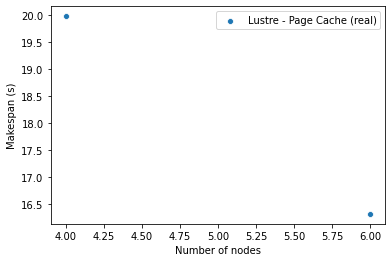

In [19]:
df = pd.read_csv("../../metadata/results/exp_opennb.out").dropna(subset={"runtime"})
df['nodes'] = df['experiment'].apply(lambda cell: int(cell.split("_")[1].rstrip("n")))
df = df.sort_values(by=["nodes"])
sns.scatterplot(data=df, x="nodes", y="runtime", label="Lustre - Page Cache (real)")
plt.xlabel("Number of nodes")
plt.ylabel("Makespan (s)")

In [22]:
import figures as fg
data = "../../metadata/results/exp_opennb/run-0/lustre_6n_6t_6d_1000f_617m_5i/benchmarks.out"
df = fg.load_df(data)
df.loc[df["action"] == "open", "action"] = "read"
print(df.groupby("action")["duration"].mean())
fg.bokeh_gantt(df)

action
read    0.059564
Name: duration, dtype: float64


Loading BokehJS ...